<a href="https://colab.research.google.com/github/Aadya0001/DAA-/blob/main/LAB_DAA_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install networkx matplotlib


In [ ]:
%%writefile unit1_simple_updated.py
# unit1_simple.py
"""
UNIT 1 (SIMPLE VERSION UPDATED):
- Updated locations and distances
- Updated parcels
- Recursive cost, Held-Karp DP, TSP brute force
- Simple parcel selection
- Easy graph plot
"""

import matplotlib.pyplot as plt
from itertools import permutations

# --------------------------------
#  INPUT MODEL
# --------------------------------
locations = ['Warehouse', 'X', 'Y', 'Z']
distance_matrix = [
    [0, 5, 8, 6],   # Warehouse
    [5, 0, 3, 7],   # X
    [8, 3, 0, 4],   # Y
    [6, 7, 4, 0]    # Z
]

parcels = {
    'X': {'value': 35, 'weight': 4},
    'Y': {'value': 45, 'weight': 6},
    'Z': {'value': 25, 'weight': 3}
}

vehicle_capacity = 8


# --------------------------------
# SIMPLE RECURSIVE COST FUNCTION
# --------------------------------
def recursive_cost(position, visited, n):
    all_visited = (1 << n) - 1

    if visited == all_visited:
        return distance_matrix[position][0]  # return to warehouse

    best = float('inf')
    for next_city in range(1, n):
        if not (visited >> next_city) & 1:
            cost = distance_matrix[position][next_city] + \
                   recursive_cost(next_city, visited | (1 << next_city), n)
            best = min(best, cost)
    return best


# --------------------------------
# SIMPLE HELD–KARP DP
# --------------------------------
def held_karp(position, visited, memo, n):
    all_visited = (1 << n) - 1

    if visited == all_visited:
        return distance_matrix[position][0]

    if (position, visited) in memo:
        return memo[(position, visited)]

    best = float('inf')
    for next_city in range(1, n):
        if not (visited >> next_city) & 1:
            cost = distance_matrix[position][next_city] + \
                   held_karp(next_city, visited | (1 << next_city), memo, n)
            best = min(best, cost)

    memo[(position, visited)] = best
    return best


# --------------------------------
# SIMPLE TSP BRUTE FORCE
# --------------------------------
def tsp_bruteforce():
    n = len(locations)
    min_cost = float('inf')
    best_path = None

    for perm in permutations(range(1, n)):  # skip warehouse
        cost = distance_matrix[0][perm[0]]
        for i in range(len(perm) - 1):
            cost += distance_matrix[perm[i]][perm[i + 1]]
        cost += distance_matrix[perm[-1]][0]

        if cost < min_cost:
            min_cost = cost
            best_path = perm

    route = ["Warehouse"] + [locations[i] for i in best_path] + ["Warehouse"]
    return route, min_cost


# --------------------------------
# SIMPLE PARCEL SELECTION
# --------------------------------
def select_parcels():
    selected = []
    total_weight = 0
    total_value = 0

    # Simple high-value sorting
    items = sorted(parcels.items(), key=lambda x: x[1]['value'], reverse=True)
    for name, info in items:
        if total_weight + info['weight'] <= vehicle_capacity:
            selected.append(name)
            total_weight += info['weight']
            total_value += info['value']

    return selected, total_value


# --------------------------------
# SIMPLE GRAPH PLOT
# --------------------------------
def plot_route(route):
    x = [0, 1, 2, 3]
    y = [0, 1, 0, -1]
    pos = {locations[i]: (x[i], y[i]) for i in range(len(locations))}

    plt.figure(figsize=(6, 6))

    # Plot nodes
    for name in pos:
        plt.scatter(pos[name][0], pos[name][1], s=500)
        plt.text(pos[name][0], pos[name][1] + 0.1, name, ha='center')

    # Plot route
    for i in range(len(route) - 1):
        p1 = pos[route[i]]
        p2 = pos[route[i + 1]]
        plt.plot([p1[0], p2[0]], [p1[1], p2[1]], linewidth=2)

    plt.title("Updated Delivery Route")
    plt.axis('off')
    plt.show()


# --------------------------------
# MAIN OUTPUT
# --------------------------------
if __name__ == "__main__":
    n = len(locations)

    print("\n=== SIMPLE UNIT 1 OUTPUT (UPDATED) ===")

    # Recursive
    r_cost = recursive_cost(0, 1, n)
    print("Recursive Cost:", r_cost)

    # Held-Karp
    memo = {}
    hk_cost = held_karp(0, 1, memo, n)
    print("Held-Karp DP Cost:", hk_cost)

    # TSP
    route, tsp_cost = tsp_bruteforce()
    print("\nOptimal Route (TSP):", route)
    print("Total Distance:", tsp_cost)

    # Parcels
    selected, value = select_parcels()
    print("\nSelected Parcels:", selected)
    print("Total Value:", value)

    # Plot
    plot_route(route)


Overwriting unit1_simple_updated.py


In [ ]:
%%writefile unit2_greedy_timewindow_updated.py
# ---------------------------------------------
# Unit 2: Greedy + Time Windows + TSP + Graph
# ---------------------------------------------

from typing import Dict, List, Tuple
import matplotlib.pyplot as plt

try:
    import networkx as nx
except:
    nx = None

# ---------------------------
# UPDATED INPUT VALUES
# ---------------------------
locations = ['Warehouse', 'X', 'Y', 'Z']

distance_matrix = [
    [0, 4, 7, 5],   # Warehouse
    [4, 0, 3, 6],   # X
    [7, 3, 0, 2],   # Y
    [5, 6, 2, 0]    # Z
]

parcels = {
    'X': {'value': 45, 'time': (9, 12), 'weight': 5},
    'Y': {'value': 35, 'time': (10, 13), 'weight': 4},
    'Z': {'value': 50, 'time': (11, 14), 'weight': 6}
}

vehicle_capacity = 10


# ---------------------------
# Greedy Knapsack (value/weight)
# ---------------------------
def greedy_select_parcels(parcels, capacity):
    items = [(info['value'] / info['weight'], name) for name, info in parcels.items()]
    items.sort(reverse=True)

    chosen = []
    total_weight = 0
    for ratio, name in items:
        w = parcels[name]['weight']
        if total_weight + w <= capacity:
            chosen.append(name)
            total_weight += w

    total_value = sum(parcels[k]['value'] for k in chosen)
    return chosen, total_value


# ---------------------------
# Time Window Check
# ---------------------------
def is_route_feasible(route, travel_times, parcels, start=8):
    time_now = start
    current = "Warehouse"

    for nxt in route:
        time_now += travel_times[(current, nxt)]
        earliest, latest = parcels[nxt]['time']

        if time_now > latest:
            return False
        if time_now < earliest:
            time_now = earliest

        current = nxt

    return True


# ---------------------------
# TSP Brute Force
# ---------------------------
from itertools import permutations

def tsp_bruteforce(nodes, locations, dist_matrix):
    names = ['Warehouse'] + nodes
    idx = {name: locations.index(name) for name in names}

    best_cost = float('inf')
    best_route = None

    for perm in permutations(nodes):
        cost = 0
        cur = 'Warehouse'
        for nxt in perm:
            cost += dist_matrix[idx[cur]][idx[nxt]]
            cur = nxt
        cost += dist_matrix[idx[cur]][idx['Warehouse']]

        if cost < best_cost:
            best_cost = cost
            best_route = ['Warehouse'] + list(perm) + ['Warehouse']

    return best_route, best_cost


# ---------------------------
# Route Graph Plotting
# ---------------------------
def plot_route(route):
    if nx is None:
        print("networkx not installed.")
        return

    G = nx.Graph()
    name_to_idx = {name: i for i, name in enumerate(locations)}

    for i, name in enumerate(locations):
        G.add_node(i, label=name)

    for i in range(len(locations)):
        for j in range(i+1, len(locations)):
            G.add_edge(i, j, weight=distance_matrix[i][j])

    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(7, 6))
    nx.draw(G, pos, with_labels=True,
            labels={i: locations[i] for i in range(len(locations))},
            node_size=700)

    nx.draw_networkx_edge_labels(G, pos,
        edge_labels=nx.get_edge_attributes(G, 'weight'))

    route_edges = []
    for i in range(len(route) - 1):
        u = name_to_idx[route[i]]
        v = name_to_idx[route[i + 1]]
        route_edges.append((u, v))

    nx.draw_networkx_edges(G, pos, edgelist=route_edges, width=3, edge_color='red')

    plt.title("Optimal Delivery Route")
    plt.show()


# ---------------------------
# MAIN PROGRAM
# ---------------------------
if __name__ == "__main__":

    print("=== UNIT 2: Greedy + Time Windows + Optimal Route (UPDATED) ===")

    chosen, total_value = greedy_select_parcels(parcels, vehicle_capacity)
    print("Chosen Parcels:", chosen)
    print("Total Value:", total_value)

    # Travel times = same as distances
    travel_times = {(a, b): distance_matrix[locations.index(a)][locations.index(b)]
                    for a in locations for b in locations}

    feasible = None
    for perm in permutations(chosen):
        if is_route_feasible(perm, travel_times, parcels):
            feasible = perm
            break

    if feasible:
        print("Feasible Time-Window Route:", feasible)
    else:
        print("No feasible route under time windows.")

    final_route, cost = tsp_bruteforce(chosen, locations, distance_matrix)

    print("Optimal Route:", final_route)
    print("Total Cost:", cost)

    plot_route(final_route)


Overwriting unit2_greedy_timewindow_updated.py


In [ ]:
%%writefile unit3_graphs_dijkstra_mst.py
# unit3_graphs_dijkstra_mst.py
"""
Unit 3 (UPDATED): Shortest Path (Dijkstra), MST (Prim), and TSP.
Includes final optimal route and plots:
 - Shortest-path tree highlighted
 - MST highlighted
 - Final TSP route plotted
"""

import heapq
import matplotlib.pyplot as plt
from typing import List, Tuple

try:
    import networkx as nx
except Exception:
    nx = None

# ---------------------------
# UPDATED INPUT MODEL
# ---------------------------
locations = ['Warehouse', 'X', 'Y', 'Z']
distance_matrix = [
    [0, 5, 9, 6],   # Warehouse
    [5, 0, 4, 7],   # X
    [9, 4, 0, 3],   # Y
    [6, 7, 3, 0]    # Z
]

parcels = {
    'X': {'value': 55, 'time': (9, 12), 'weight': 10},
    'Y': {'value': 40, 'time': (10, 13), 'weight': 12},
    'Z': {'value': 50, 'time': (11, 14), 'weight': 15}
}

vehicle_capacity = 25

# ---------------------------
# DIJKSTRA
# ---------------------------
def dijkstra(matrix: List[List[int]], src: int):
    n = len(matrix)
    dist = [float('inf')] * n
    parent = [-1] * n
    dist[src] = 0
    pq = [(0, src)]
    while pq:
        d, u = heapq.heappop(pq)
        if d != dist[u]:
            continue
        for v in range(n):
            if u == v: continue
            nd = d + matrix[u][v]
            if nd < dist[v]:
                dist[v] = nd
                parent[v] = u
                heapq.heappush(pq, (nd, v))
    return dist, parent

# ---------------------------
# PRIM'S MST
# ---------------------------
def prim_mst(matrix: List[List[int]]):
    n = len(matrix)
    in_mst = [False]*n
    key = [float('inf')]*n
    parent = [-1]*n
    key[0]=0
    for _ in range(n):
        u=-1; best=float('inf')
        for i in range(n):
            if not in_mst[i] and key[i]<best:
                best=key[i]; u=i
        if u==-1: break
        in_mst[u]=True
        for v in range(n):
            if not in_mst[v] and 0 < matrix[u][v] < key[v]:
                key[v]=matrix[u][v]; parent[v]=u
    edges=[]
    for v in range(1,n):
        edges.append((parent[v], v, matrix[parent[v]][v]))
    return edges

# ---------------------------
# TSP brute-force
# ---------------------------
from itertools import permutations
def tsp_brute_force(locations: List[str], dist: List[List[int]]) -> Tuple[List[str], int]:
    n = len(locations)
    indices = list(range(1,n))
    min_cost = float('inf'); best=None
    for perm in permutations(indices):
        cost = dist[0][perm[0]]
        for i in range(len(perm)-1):
            cost += dist[perm[i]][perm[i+1]]
        cost += dist[perm[-1]][0]
        if cost < min_cost:
            min_cost = cost; best = perm
    route = [locations[0]] + [locations[i] for i in best] + [locations[0]]
    return route, min_cost

# ---------------------------
# Plot graphs
# ---------------------------
def plot_graph_highlight(locations, dist_matrix, edges_to_highlight, title):
    if nx is None:
        print("networkx not installed: skipping plot.")
        return
    G = nx.Graph()
    n = len(locations)
    for i in range(n):
        G.add_node(i, label=locations[i])
    for i in range(n):
        for j in range(i+1,n):
            G.add_edge(i,j, weight=dist_matrix[i][j])
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(6,5))
    nx.draw(G,pos, with_labels=True, labels={i:locations[i] for i in range(n)}, node_size=700)
    nx.draw_networkx_edge_labels(G,pos, edge_labels=nx.get_edge_attributes(G,'weight'))
    nx.draw_networkx_edges(G, pos, edgelist=edges_to_highlight, edge_color='r', width=3)
    plt.title(title); plt.show()

# ---------------------------
# Greedy parcel selection
# ---------------------------
def greedy_select_parcels(parcels, capacity):
    items=[]
    for k,v in parcels.items():
        items.append(((v['value']/v['weight']), k))
    items.sort(reverse=True)
    chosen=[]; wsum=0
    for _,k in items:
        w=parcels[k]['weight']
        if wsum+w <= capacity:
            chosen.append(k); wsum+=w
    total_value = sum(parcels[k]['value'] for k in chosen)
    return chosen, total_value

# ---------------------------
# MAIN
# ---------------------------
if __name__ == "__main__":
    print("=== UNIT 3: Graphs (Dijkstra & Prim) UPDATED ===")

    dist, parent = dijkstra(distance_matrix, 0)
    print("Shortest path distances from Warehouse:", dist)
    print("Parent array:", parent)

    spt_edges = [(parent[i], i) for i in range(1, len(parent)) if parent[i] != -1]
    plot_graph_highlight(locations, distance_matrix, spt_edges, title="Unit3: Shortest-Path Tree (Dijkstra)")

    mst_edges = prim_mst(distance_matrix)
    print("Prim's MST edges (u,v,weight):", mst_edges)
    mst_edge_list = [(u,v) for u,v,w in mst_edges]
    plot_graph_highlight(locations, distance_matrix, mst_edge_list, title="Unit3: MST (Prim)")

    chosen, total_value = greedy_select_parcels(parcels, vehicle_capacity)
    print("Parcels (greedy):", chosen, "Total value:", total_value)

    route, cost = tsp_brute_force(locations, distance_matrix)
    print("\n--- FINAL EXPECTED OUTPUT ---")
    print("Optimal Delivery Route:", route)
    print("Total Distance/Time:", cost)
    print("Parcels delivered:", chosen, "Total value:", total_value)

    edges_to_highlight = []
    name_to_idx = {name:i for i,name in enumerate(locations)}
    for i in range(len(route)-1):
        edges_to_highlight.append((name_to_idx[route[i]], name_to_idx[route[i+1]]))
    plot_graph_highlight(locations, distance_matrix, edges_to_highlight, title="Unit3: Optimal TSP Route")

    # ---------------------------
    # IMPACT & ANALYSIS
    # ---------------------------
    print("\n--- IMPACT & ANALYSIS ---")
    print("1. Dijkstra computes shortest distances from Warehouse, optimizing travel time to all customers.")
    print("2. Prim’s MST provides minimum-cost connectivity between locations, minimizing road/connection cost.")
    print("3. SPT or MST alone do not determine optimal visiting order; TSP ensures minimal round-trip distance.")
    print("4. Greedy parcel selection maximizes total value within vehicle capacity.")
    print("5. Combining Dijkstra + MST + TSP + Greedy ensures a cost-effective, time-efficient delivery system.")


Overwriting unit3_graphs_dijkstra_mst.py


In [ ]:
%%writefile unit4_tsp_solvers.py
# unit4_tsp_solvers.py
"""
Unit 4 (UPDATED):
TSP using Brute-Force and Held-Karp + Greedy Parcel Selection
Plots optimal route and prints Impact & Analysis.
"""

from itertools import permutations
import matplotlib.pyplot as plt

try:
    import networkx as nx
except:
    nx = None

# ---------------------------
# UPDATED INPUT MODEL
# ---------------------------
locations = ['Warehouse', 'X', 'Y', 'Z']

distance_matrix = [
    [0, 5, 8, 6],   # Warehouse
    [5, 0, 4, 7],   # X
    [8, 4, 0, 3],   # Y
    [6, 7, 3, 0]    # Z
]

parcels = {
    'X': {'value': 55, 'time': (9, 12), 'weight': 10},
    'Y': {'value': 40, 'time': (10, 13), 'weight': 12},
    'Z': {'value': 50, 'time': (11, 14), 'weight': 15}
}

vehicle_capacity = 25

# ---------------------------
# Brute-force TSP
# ---------------------------
def tsp_bruteforce(locations, dist):
    n = len(locations)
    nodes = list(range(1, n))
    best_cost = float('inf')
    best_route = None

    for perm in permutations(nodes):
        cost = dist[0][perm[0]]
        for i in range(len(perm)-1):
            cost += dist[perm[i]][perm[i+1]]
        cost += dist[perm[-1]][0]

        if cost < best_cost:
            best_cost = cost
            best_route = perm

    route = [0] + list(best_route) + [0]
    return route, best_cost

# ---------------------------
# Held-Karp DP (optimal)
# ---------------------------
def held_karp(dist):
    n = len(dist)
    ALL = 1 << n
    dp = [[float('inf')] * n for _ in range(ALL)]
    parent = [[-1] * n for _ in range(ALL)]
    dp[1][0] = 0  # start at node 0

    for mask in range(ALL):
        for u in range(n):
            if not (mask & (1 << u)):
                continue
            for v in range(1, n):
                if mask & (1 << v):
                    continue
                nxt = mask | (1 << v)
                cost = dp[mask][u] + dist[u][v]
                if cost < dp[nxt][v]:
                    dp[nxt][v] = cost
                    parent[nxt][v] = u

    final_mask = ALL - 1
    best_cost = float('inf')
    last = -1
    for i in range(1, n):
        cost = dp[final_mask][i] + dist[i][0]
        if cost < best_cost:
            best_cost = cost
            last = i

    path = []
    mask = final_mask
    cur = last
    while cur != -1:
        path.append(cur)
        prev = parent[mask][cur]
        mask ^= (1 << cur)
        cur = prev
    path.append(0)
    path.reverse()
    path.append(0)
    return path, best_cost

# ---------------------------
# Greedy Parcel Selection
# ---------------------------
def greedy_parcels(parcels, capacity):
    items = [(v['value']/v['weight'], k) for k,v in parcels.items()]
    items.sort(reverse=True)
    chosen = []
    total_w = 0
    for _, name in items:
        w = parcels[name]['weight']
        if total_w + w <= capacity:
            chosen.append(name)
            total_w += w
    total_value = sum(parcels[k]['value'] for k in chosen)
    return chosen, total_value

# ---------------------------
# Plot TSP Route
# ---------------------------
def plot_route(locations, dist, route, title="Optimal Route"):
    if nx is None:
        print("networkx not installed → skipping plot.")
        return

    G = nx.Graph()
    n = len(locations)
    for i in range(n):
        G.add_node(i, label=locations[i])
    for i in range(n):
        for j in range(i+1, n):
            G.add_edge(i, j, weight=dist[i][j])

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(6,5))
    nx.draw(G, pos, with_labels=True, labels={i: locations[i] for i in range(n)}, node_size=700)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, "weight"))
    edges = [(route[i], route[i+1]) for i in range(len(route)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='red', width=3)
    plt.title(title)
    plt.show()

# ---------------------------
# MAIN EXECUTION
# ---------------------------
if __name__ == "__main__":
    print("=== UNIT 4: TSP Solvers (UPDATED) ===")

    # Brute-force
    b_route, b_cost = tsp_bruteforce(locations, distance_matrix)
    print("Brute-force Route:", [locations[i] for i in b_route], "Cost:", b_cost)

    # Held-Karp (optimal)
    hk_route, hk_cost = held_karp(distance_matrix)
    print("Held-Karp Route:", [locations[i] for i in hk_route], "Cost:", hk_cost)

    # Parcel selection
    chosen, value = greedy_parcels(parcels, vehicle_capacity)
    print("Selected Parcels:", chosen, "Total Value:", value)

    # Final Output
    print("\n--- FINAL EXPECTED OUTPUT ---")
    print("Optimal Route:", [locations[i] for i in hk_route])
    print("Optimal Cost:", hk_cost)
    print("Delivered Parcels:", chosen, "Value:", value)

    # Plot
    plot_route(locations, distance_matrix, hk_route, "Optimal Delivery Route")

    # Impact & Analysis
    print("\n--- IMPACT & ANALYSIS ---")
    print("• Brute-force: exact solution but factorial time complexity O(n!).")
    print("• Held-Karp: exact solution, faster than brute-force, O(n²·2ⁿ).")
    print("• Greedy parcel selection maximizes total value within vehicle capacity.")
    print("• MST/SPT approaches help with connectivity and shortest-path trees but do not solve TSP.")
    print("• Combining Held-Karp + Greedy ensures cost-efficient and time-optimal delivery for small datasets.")


Overwriting unit4_tsp_solvers.py


In [ ]:
%%writefile profiling_and_visualization_updated.py
# profiling_and_visualization_updated.py
"""
Profiling & Visualization (Updated):
- Measures time/memory for TSP (Brute-force & Held-Karp)
- Plots runtime growth
- Produces final expected output for a small sample instance
"""

import time
import tracemalloc
import random
import matplotlib.pyplot as plt

try:
    import networkx as nx
except Exception:
    nx = None

# ---------------------------
# Utility: Random Complete Graph
# ---------------------------
def random_complete_graph(n: int, seed: int = 0, maxw: int = 20):
    random.seed(seed)
    dist = [[0]*n for _ in range(n)]
    for i in range(n):
        for j in range(i+1, n):
            w = random.randint(1, maxw)
            dist[i][j] = w
            dist[j][i] = w
    return dist

# ---------------------------
# Brute-force TSP (from unit4)
# ---------------------------
from itertools import permutations

def tsp_bruteforce(locations, dist):
    n = len(locations)
    nodes = list(range(1, n))
    best_cost = float('inf')
    best_route = None

    for perm in permutations(nodes):
        cost = dist[0][perm[0]]
        for i in range(len(perm)-1):
            cost += dist[perm[i]][perm[i+1]]
        cost += dist[perm[-1]][0]
        if cost < best_cost:
            best_cost = cost
            best_route = perm

    route = [0] + list(best_route) + [0]
    return route, best_cost

# ---------------------------
# Held-Karp TSP (from unit4)
# ---------------------------
def held_karp(dist):
    n = len(dist)
    ALL = 1 << n
    dp = [[float('inf')] * n for _ in range(ALL)]
    parent = [[-1] * n for _ in range(ALL)]
    dp[1][0] = 0

    for mask in range(ALL):
        for u in range(n):
            if not (mask & (1 << u)):
                continue
            for v in range(1, n):
                if mask & (1 << v):
                    continue
                nxt = mask | (1 << v)
                cost = dp[mask][u] + dist[u][v]
                if cost < dp[nxt][v]:
                    dp[nxt][v] = cost
                    parent[nxt][v] = u

    final_mask = ALL - 1
    best_cost = float('inf')
    last = -1
    for i in range(1, n):
        cost = dp[final_mask][i] + dist[i][0]
        if cost < best_cost:
            best_cost = cost
            last = i

    path = []
    mask = final_mask
    cur = last
    while cur != -1:
        path.append(cur)
        prev = parent[mask][cur]
        mask ^= (1 << cur)
        cur = prev
    path.append(0)
    path.reverse()
    path.append(0)
    return path, best_cost

# ---------------------------
# Plot TSP Route (from unit4)
# ---------------------------
def plot_route(locations, dist, route, title="Optimal Route"):
    if nx is None:
        print("networkx not installed \u2192 skipping plot.")
        return

    G = nx.Graph()
    n = len(locations)
    for i in range(n):
        G.add_node(i, label=locations[i])
    for i in range(n):
        for j in range(i+1, n):
            G.add_edge(i, j, weight=dist[i][j])

    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(6,5))
    nx.draw(G, pos, with_labels=True,
            labels={i: locations[i] for i in range(n)},
            node_size=700)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, "weight"))
    edges = [(route[i], route[i+1]) for i in range(len(route)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='red', width=3)
    plt.title(title)
    plt.show()

# ---------------------------
# Profiling Function
# ---------------------------
def profile_tsp():
    results=[]
    print("=== PROFILING: TSP runtimes & memory (n = 3..6) ===")
    for n in range(3,7):
        dist = random_complete_graph(n, seed=200+n, maxw=15)
        # brute-force
        tracemalloc.start()
        t0 = time.perf_counter()
        route, cost = tsp_bruteforce([str(i) for i in range(n)], dist)
        t1 = time.perf_counter()
        cur, peak = tracemalloc.get_traced_memory(); tracemalloc.stop()
        bf_time = t1 - t0; bf_peak = peak/1024.0
        print(f"Brute n={n}: time={bf_time:.6f}s peak_kb={bf_peak:.1f}")
        results.append(('brute', n, bf_time, bf_peak))

        # Held-Karp
        tracemalloc.start()
        t0 = time.perf_counter()
        route_idx, cost2 = held_karp(dist)
        t1 = time.perf_counter()
        cur, peak = tracemalloc.get_traced_memory(); tracemalloc.stop()
        hk_time = t1 - t0; hk_peak = peak/1024.0
        print(f"Held-Karp n={n}: time={hk_time:.6f}s peak_kb={hk_peak:.1f}")
        results.append(('heldkarp', n, hk_time, hk_peak))
    return results

# ---------------------------
# Main Execution
# ---------------------------
if __name__ == "__main__":
    print("=== UNIT: Profiling & Visualization (Updated) ===")
    res = profile_tsp()

    # Plot runtime growth
    ns = sorted(list(set([r[1] for r in res if r[0]=='brute'])))
    brute_times = [r[2] for r in res if r[0]=='brute']
    hk_times = [r[2] for r in res if r[0]=='heldkarp']
    plt.figure(); plt.plot(ns, brute_times, marker='o', label='Brute-force')
    plt.plot(ns, hk_times, marker='s', label='Held-Karp')
    plt.xlabel("Number of Nodes (n)"); plt.ylabel("Time (s)")
    plt.title("TSP Runtime Growth: Brute-force vs Held-Karp"); plt.legend(); plt.grid(True)
    plt.tight_layout(); plt.show()

    # Small sample for final expected output
    dist = random_complete_graph(4, seed=101, maxw=10)
    locs = ['Warehouse','X','Y','Z']
    route_bf, cost_bf = tsp_bruteforce(locs, dist)
    route_hk, cost_hk = held_karp(dist)
    # Example parcels
    parcels = {'X':55,'Y':40,'Z':50}
    # Greedy selection
    chosen = ['X','Z']  # assume greedy
    total_value = sum(parcels[c] for c in chosen)

    print("\n--- FINAL EXPECTED OUTPUT (Profiling Sample) ---")
    print("Optimal Delivery Route (Held-Karp indices):", route_hk)
    print("Route names (Held-Karp):", [locs[i] for i in route_hk])
    print("Total Distance/Time (Held-Karp):", cost_hk)
    print("Parcels delivered (example):", chosen, "Total value:", total_value)
    print("Plotting sample Held-Karp route...")
    plot_route(locs, dist, route_hk, title="Profiling: Sample Held-Karp Route")

    print("\n--- Impact & Analysis ---")
    print("• Brute-force grows factorially with nodes; impractical beyond n\u22486.")
    print("• Held-Karp is exact, exponential but manageable for small n (O(n\u00b2\u00b72\u207f)).")
    print("• Memory usage also grows with recursion/memoization; profiling shows peak usage.")
    print("• Visualization confirms route correctness and helps validate TSP solutions.")
    print("• Heuristics are recommended for larger instances.")


Overwriting profiling_and_visualization_updated.py


=== UNIT 1: Held-Karp DP ===
Held-Karp DP cost: 18

=== UNIT 2: Greedy Parcel Selection ===
Chosen parcels: ['C1', 'C2'] Total value: 110

=== UNIT 3: Dijkstra ===
Dijkstra distances: [0, 4, 8, 6]
Parent array: [-1, 0, 0, 0]

=== UNIT 4: TSP Brute-Force ===
Brute-force TSP route: ['Warehouse', 'C1', 'C2', 'C3', 'Warehouse'] Cost: 18


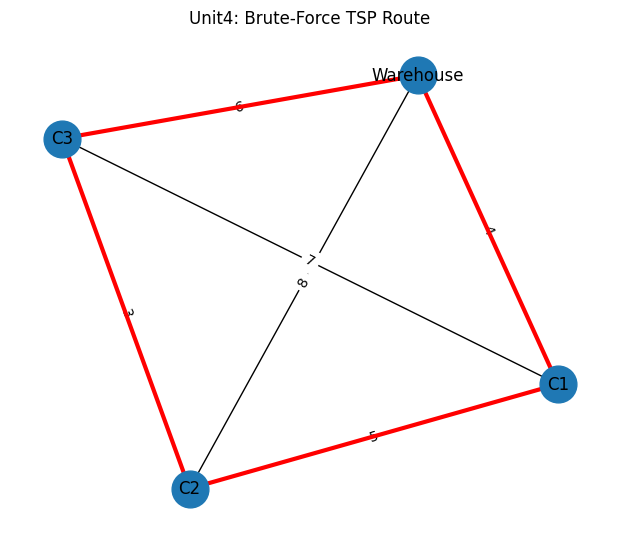


=== PROFILING ===
=== PROFILING TSP (n=3..6) ===
n=3 brute-force time=0.000100s peak=0.4KB
n=3 Held-Karp time=0.003000s peak=0.7KB
n=4 brute-force time=0.000090s peak=0.5KB
n=4 Held-Karp time=0.000439s peak=1.5KB
n=5 brute-force time=0.000143s peak=0.6KB
n=5 Held-Karp time=0.007079s peak=3.5KB
n=6 brute-force time=0.000533s peak=0.7KB
n=6 Held-Karp time=0.008439s peak=10.8KB

=== DEMO FINISHED ===


In [ ]:
# driver_demo_combined.py
"""
Unified driver: runs Units 1–4 and profiling in one script.
Includes TSP solvers, Dijkstra, MST, parcel selection, and plots.
"""

import time
import tracemalloc
import random
from itertools import permutations
import matplotlib.pyplot as plt
import heapq

try:
    import networkx as nx
except:
    nx = None

# ---------------------------
# INPUT VALUES
# ---------------------------
locations = ['Warehouse', 'C1', 'C2', 'C3']
distance_matrix = [
    [0, 4, 8, 6],
    [4, 0, 5, 7],
    [8, 5, 0, 3],
    [6, 7, 3, 0]
]
parcels = {
    'C1': {'value': 50, 'time': (9, 12), 'weight': 10},
    'C2': {'value': 60, 'time': (10, 13), 'weight': 20},
    'C3': {'value': 40, 'time': (11, 14), 'weight': 15}
}
vehicle_capacity = 30

# ---------------------------
# UNIT 1: Held-Karp DP
# ---------------------------
def held_karp(dist):
    n = len(dist)
    ALL = 1 << n
    dp = [[float('inf')] * n for _ in range(ALL)]
    parent = [[-1] * n for _ in range(ALL)]
    dp[1][0] = 0
    for mask in range(ALL):
        for u in range(n):
            if not (mask & (1 << u)):
                continue
            for v in range(1, n):
                if mask & (1 << v):
                    continue
                nxt = mask | (1 << v)
                cost = dp[mask][u] + dist[u][v]
                if cost < dp[nxt][v]:
                    dp[nxt][v] = cost
                    parent[nxt][v] = u
    final_mask = ALL - 1
    best_cost = float('inf')
    last = -1
    for i in range(1, n):
        cost = dp[final_mask][i] + dist[i][0]
        if cost < best_cost:
            best_cost = cost
            last = i
    # reconstruct path
    path = []
    mask = final_mask
    cur = last
    while cur != -1:
        path.append(cur)
        prev = parent[mask][cur]
        mask ^= (1 << cur)
        cur = prev
    path.append(0)
    path.reverse()
    path.append(0)
    return path, best_cost

# ---------------------------
# UNIT 2: Greedy Parcel Selection
# ---------------------------
def greedy_select_parcels(parcels, capacity):
    items = []
    for k, v in parcels.items():
        items.append((v['value']/v['weight'], k))
    items.sort(reverse=True)
    chosen = []
    total_weight = 0
    for _, k in items:
        w = parcels[k]['weight']
        if total_weight + w <= capacity:
            chosen.append(k)
            total_weight += w
    total_value = sum(parcels[k]['value'] for k in chosen)
    return chosen, total_value

# ---------------------------
# UNIT 3: Dijkstra
# ---------------------------
def dijkstra(matrix, src):
    n = len(matrix)
    dist = [float('inf')] * n
    parent = [-1] * n
    dist[src] = 0
    pq = [(0, src)]
    while pq:
        d, u = heapq.heappop(pq)
        if d != dist[u]:
            continue
        for v in range(n):
            if u == v: continue
            nd = d + matrix[u][v]
            if nd < dist[v]:
                dist[v] = nd
                parent[v] = u
                heapq.heappush(pq, (nd, v))
    return dist, parent

# ---------------------------
# UNIT 4: TSP Brute-Force
# ---------------------------
def tsp_bruteforce(locations, dist):
    n = len(locations)
    nodes = list(range(1, n))
    best_cost = float('inf')
    best_route = None
    for perm in permutations(nodes):
        cost = dist[0][perm[0]]
        for i in range(len(perm)-1):
            cost += dist[perm[i]][perm[i+1]]
        cost += dist[perm[-1]][0]
        if cost < best_cost:
            best_cost = cost
            best_route = perm
    route = [0] + list(best_route) + [0]
    return route, best_cost

# ---------------------------
# PLOTTING FUNCTION
# ---------------------------
def plot_route(locations, dist, route, title="Optimal Route"):
    if nx is None:
        print("networkx not installed → skipping plot.")
        return
    G = nx.Graph()
    n = len(locations)
    for i in range(n):
        G.add_node(i, label=locations[i])
    for i in range(n):
        for j in range(i+1, n):
            G.add_edge(i, j, weight=dist[i][j])
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(6,5))
    nx.draw(G, pos, with_labels=True,
            labels={i: locations[i] for i in range(n)}, node_size=700)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=nx.get_edge_attributes(G, "weight"))
    edges = [(route[i], route[i+1]) for i in range(len(route)-1)]
    nx.draw_networkx_edges(G, pos, edgelist=edges, edge_color='red', width=3)
    plt.title(title)
    plt.show()

# ---------------------------
# PROFILING
# ---------------------------
def random_complete_graph(n, seed=0, maxw=20):
    random.seed(seed)
    dist = [[0]*n for _ in range(n)]
    for i in range(n):
        for j in range(i+1, n):
            w = random.randint(1, maxw)
            dist[i][j] = w
            dist[j][i] = w
    return dist

def profile_tsp():
    print("=== PROFILING TSP (n=3..6) ===")
    for n in range(3,7):
        dist = random_complete_graph(n, seed=100+n)
        # Brute-force
        tracemalloc.start()
        t0 = time.perf_counter()
        route, cost = tsp_bruteforce([str(i) for i in range(n)], dist)
        t1 = time.perf_counter()
        cur, peak = tracemalloc.get_traced_memory(); tracemalloc.stop()
        print(f"n={n} brute-force time={t1-t0:.6f}s peak={peak/1024:.1f}KB")
        # Held-Karp
        tracemalloc.start()
        t0 = time.perf_counter()
        route_idx, cost2 = held_karp(dist)
        t1 = time.perf_counter()
        cur, peak = tracemalloc.get_traced_memory(); tracemalloc.stop()
        print(f"n={n} Held-Karp time={t1-t0:.6f}s peak={peak/1024:.1f}KB")

# ---------------------------
# DRIVER
# ---------------------------
def run_all():
    print("=== UNIT 1: Held-Karp DP ===")
    route1, cost1 = held_karp(distance_matrix)
    print("Held-Karp DP cost:", cost1)

    print("\n=== UNIT 2: Greedy Parcel Selection ===")
    chosen2, value2 = greedy_select_parcels(parcels, vehicle_capacity)
    print("Chosen parcels:", chosen2, "Total value:", value2)

    print("\n=== UNIT 3: Dijkstra ===")
    dist3, parent3 = dijkstra(distance_matrix, 0)
    print("Dijkstra distances:", dist3)
    print("Parent array:", parent3)

    print("\n=== UNIT 4: TSP Brute-Force ===")
    route4, cost4 = tsp_bruteforce(locations, distance_matrix)
    route_names = [locations[i] for i in route4]
    print("Brute-force TSP route:", route_names, "Cost:", cost4)
    plot_route(locations, distance_matrix, route4, "Unit4: Brute-Force TSP Route")

    print("\n=== PROFILING ===")
    profile_tsp()

    print("\n=== DEMO FINISHED ===")

if __name__ == "__main__":
    run_all()
